In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ---------------------------------------
# 1. Data Loading and Inspection
# ---------------------------------------
train_data = pd.read_csv('/content/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/content/Google_Stock_Price_Test.csv')

print("Training Data Sample:\n", train_data.head())
print("Test Data Sample:\n", test_data.head())
print("Missing values in training data:\n", train_data.isnull().sum())

Training Data Sample:
        Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Test Data Sample:
        Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
Missing values in training data:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# ---------------------------------------
# 2. Data Cleaning and Preprocessing
# ---------------------------------------
features = ['Open', 'High', 'Low', 'Close']

# Convert columns that are object type with commas into float
for feature in features:
    if train_data[feature].dtype == 'object':
        train_data[feature] = train_data[feature].str.replace(',', '', regex=True).astype(float)
    if test_data[feature].dtype == 'object':
        test_data[feature] = test_data[feature].str.replace(',', '', regex=True).astype(float)

training_set = train_data[features].values
test_set = test_data[features].values

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(training_set)

In [ ]:
# ---------------------------------------
# 3. Fixed-length Sequence Creation (Sliding Window)
# ---------------------------------------
N = 30  # number of past days to use as input
M = 1   # number of future days to predict

X, y = [], []
for i in range(N, len(training_set_scaled) - M + 1):
    X.append(training_set_scaled[i-N:i, :])
    y.append(training_set_scaled[i:i+M, :])

X, y = np.array(X), np.array(y)

# Split into training and validation sets (time-aware)
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [ ]:
# ---------------------------------------
# 4. Dataset and DataLoader
# ---------------------------------------
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# ---------------------------------------
# 5. LSTM with Attention Model Definition
# ---------------------------------------
class LSTMModel(nn.Module):#Attention
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)  # Compute attention scores
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: [B, T, input_dim]
        lstm_out, _ = self.lstm(x)  # lstm_out: [B, T, hidden_dim]

        # Compute attention scores
        attn_scores = self.attention(lstm_out)  # attn_scores: [B, T, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)  # Normalize scores: [B, T, 1]

        # Compute context vector as weighted sum of LSTM outputs
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)  # context_vector: [B, hidden_dim]

        # Pass the context vector through the fully connected layer
        out = self.fc(context_vector)  # out: [B, output_dim]
        return out

In [ ]:
# ---------------------------------------
# 6. Custom Asymmetric Loss Function
# ---------------------------------------
class AsymmetricLoss(nn.Module):
    def __init__(self, ratio=2.0):
        super(AsymmetricLoss, self).__init__()
        self.ratio = ratio

    def forward(self, pred, target):
        diff = target - pred
        loss = torch.mean(torch.where(diff > 0, self.ratio * diff**2, diff**2))
        return loss

In [ ]:
# ---------------------------------------
# 7. Training Function with Metric Logging
# ---------------------------------------
def train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(outputs.shape))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch.view(outputs.shape))
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return best_state, best_val_loss, train_losses, val_losses

In [ ]:
# ---------------------------------------
# 8. Hyperparameter Tuning with Optuna
# ---------------------------------------
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 20, 100)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    ratio = trial.suggest_float('asymmetric_ratio', 1.0, 5.0)

    model = LSTMModel(input_dim=len(features), hidden_dim=hidden_dim, output_dim=len(features)).to(device)
    criterion = AsymmetricLoss(ratio=ratio)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

    # Shorter training for tuning
    best_state, best_val_loss, _, _ = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-06 21:57:58,387] A new study created in memory with name: no-name-54fa3cda-5a4f-4b0b-a088-6471c2e91202


Epoch 1/30, Train Loss: 0.0479, Val Loss: 0.0641
Epoch 2/30, Train Loss: 0.1176, Val Loss: 0.0414
Epoch 3/30, Train Loss: 0.0822, Val Loss: 0.0246
Epoch 4/30, Train Loss: 0.0596, Val Loss: 0.0192
Epoch 5/30, Train Loss: 0.0461, Val Loss: 0.0165
Epoch 6/30, Train Loss: 0.0338, Val Loss: 0.0091
Epoch 7/30, Train Loss: 0.0259, Val Loss: 0.0116
Epoch 8/30, Train Loss: 0.0151, Val Loss: 0.0049
Epoch 9/30, Train Loss: 0.0504, Val Loss: 0.0538
Epoch 10/30, Train Loss: 0.0237, Val Loss: 0.0161
Epoch 11/30, Train Loss: 0.0287, Val Loss: 0.0475
Epoch 12/30, Train Loss: 0.0130, Val Loss: 0.0046
Epoch 13/30, Train Loss: 0.0141, Val Loss: 0.0074
Epoch 14/30, Train Loss: 0.0222, Val Loss: 0.0298
Epoch 15/30, Train Loss: 0.0098, Val Loss: 0.0035
Epoch 16/30, Train Loss: 0.0096, Val Loss: 0.0035
Epoch 17/30, Train Loss: 0.0161, Val Loss: 0.0138
Epoch 18/30, Train Loss: 0.0089, Val Loss: 0.0038
Epoch 19/30, Train Loss: 0.0075, Val Loss: 0.0038
Epoch 20/30, Train Loss: 0.0095, Val Loss: 0.0037
Epoch 21/

[I 2024-12-06 21:58:25,682] Trial 0 finished with value: 0.003456990481936373 and parameters: {'hidden_dim': 76, 'lr': 0.005002926089694958, 'weight_decay': 0.0002481140682782569, 'asymmetric_ratio': 3.163660506438878}. Best is trial 0 with value: 0.003456990481936373.


Epoch 30/30, Train Loss: 0.0053, Val Loss: 0.0044
Epoch 1/30, Train Loss: 0.3962, Val Loss: 0.9506
Epoch 2/30, Train Loss: 0.0646, Val Loss: 0.0856
Epoch 3/30, Train Loss: 0.0654, Val Loss: 0.0457
Epoch 4/30, Train Loss: 0.0610, Val Loss: 0.0439
Epoch 5/30, Train Loss: 0.0501, Val Loss: 0.0353
Epoch 6/30, Train Loss: 0.0438, Val Loss: 0.0289
Epoch 7/30, Train Loss: 0.0406, Val Loss: 0.0262
Epoch 8/30, Train Loss: 0.0391, Val Loss: 0.0247
Epoch 9/30, Train Loss: 0.0385, Val Loss: 0.0224
Epoch 10/30, Train Loss: 0.0373, Val Loss: 0.0197
Epoch 11/30, Train Loss: 0.0348, Val Loss: 0.0154
Epoch 12/30, Train Loss: 0.0304, Val Loss: 0.0093
Epoch 13/30, Train Loss: 0.0245, Val Loss: 0.0133
Epoch 14/30, Train Loss: 0.0177, Val Loss: 0.0337
Epoch 15/30, Train Loss: 0.0134, Val Loss: 0.0237
Epoch 16/30, Train Loss: 0.0166, Val Loss: 0.0090
Epoch 17/30, Train Loss: 0.0142, Val Loss: 0.0139
Epoch 18/30, Train Loss: 0.0125, Val Loss: 0.0084
Epoch 19/30, Train Loss: 0.0151, Val Loss: 0.0056
Epoch 20/

[I 2024-12-06 21:58:38,402] Trial 1 finished with value: 0.005624490062473342 and parameters: {'hidden_dim': 67, 'lr': 0.0004280270310743036, 'weight_decay': 6.886242721291888e-05, 'asymmetric_ratio': 2.629193776235757}. Best is trial 0 with value: 0.003456990481936373.


Epoch 30/30, Train Loss: 0.0078, Val Loss: 0.0072
Epoch 1/30, Train Loss: 0.1454, Val Loss: 0.2118
Epoch 2/30, Train Loss: 0.1261, Val Loss: 0.1135
Epoch 3/30, Train Loss: 0.0882, Val Loss: 0.0755
Epoch 4/30, Train Loss: 0.0717, Val Loss: 0.0494
Epoch 5/30, Train Loss: 0.0577, Val Loss: 0.0625
Epoch 6/30, Train Loss: 0.0535, Val Loss: 0.0443
Epoch 7/30, Train Loss: 0.0573, Val Loss: 0.0331
Epoch 8/30, Train Loss: 0.0603, Val Loss: 0.0374
Epoch 9/30, Train Loss: 0.0510, Val Loss: 0.0151
Epoch 10/30, Train Loss: 0.0225, Val Loss: 0.0110
Epoch 11/30, Train Loss: 0.0324, Val Loss: 0.0113
Epoch 12/30, Train Loss: 0.0353, Val Loss: 0.0142
Epoch 13/30, Train Loss: 0.0123, Val Loss: 0.0090
Epoch 14/30, Train Loss: 0.0127, Val Loss: 0.0098
Epoch 15/30, Train Loss: 0.0170, Val Loss: 0.0038
Epoch 16/30, Train Loss: 0.0098, Val Loss: 0.0060
Epoch 17/30, Train Loss: 0.0128, Val Loss: 0.0074
Epoch 18/30, Train Loss: 0.0153, Val Loss: 0.0040
Epoch 19/30, Train Loss: 0.0102, Val Loss: 0.0048
Epoch 20/

[I 2024-12-06 21:58:52,544] Trial 2 finished with value: 0.0038407302054110914 and parameters: {'hidden_dim': 81, 'lr': 0.0014735728101582548, 'weight_decay': 4.3003240320982855e-05, 'asymmetric_ratio': 4.766467285287922}. Best is trial 0 with value: 0.003456990481936373.


Epoch 30/30, Train Loss: 0.0080, Val Loss: 0.0044
Epoch 1/30, Train Loss: 0.6214, Val Loss: 0.9598
Epoch 2/30, Train Loss: 0.0831, Val Loss: 0.2363
Epoch 3/30, Train Loss: 0.0712, Val Loss: 0.1198
Epoch 4/30, Train Loss: 0.0672, Val Loss: 0.0997
Epoch 5/30, Train Loss: 0.0610, Val Loss: 0.0807
Epoch 6/30, Train Loss: 0.0562, Val Loss: 0.0629
Epoch 7/30, Train Loss: 0.0537, Val Loss: 0.0512
Epoch 8/30, Train Loss: 0.0533, Val Loss: 0.0452
Epoch 9/30, Train Loss: 0.0536, Val Loss: 0.0431
Epoch 10/30, Train Loss: 0.0521, Val Loss: 0.0395
Epoch 11/30, Train Loss: 0.0424, Val Loss: 0.0273
Epoch 12/30, Train Loss: 0.0238, Val Loss: 0.0093
Epoch 13/30, Train Loss: 0.0137, Val Loss: 0.0063
Epoch 14/30, Train Loss: 0.0125, Val Loss: 0.0079
Epoch 15/30, Train Loss: 0.0129, Val Loss: 0.0057
Epoch 16/30, Train Loss: 0.0118, Val Loss: 0.0068
Epoch 17/30, Train Loss: 0.0108, Val Loss: 0.0085
Epoch 18/30, Train Loss: 0.0111, Val Loss: 0.0077
Epoch 19/30, Train Loss: 0.0111, Val Loss: 0.0071
Epoch 20/

[I 2024-12-06 21:59:07,293] Trial 3 finished with value: 0.005720030778320506 and parameters: {'hidden_dim': 77, 'lr': 0.00048494820527535956, 'weight_decay': 8.914842957654767e-05, 'asymmetric_ratio': 4.047793089561095}. Best is trial 0 with value: 0.003456990481936373.


Epoch 30/30, Train Loss: 0.0084, Val Loss: 0.0086
Epoch 1/30, Train Loss: 0.0429, Val Loss: 0.0560
Epoch 2/30, Train Loss: 0.1349, Val Loss: 0.0646
Epoch 3/30, Train Loss: 0.0799, Val Loss: 0.0397
Epoch 4/30, Train Loss: 0.0523, Val Loss: 0.0285
Epoch 5/30, Train Loss: 0.0397, Val Loss: 0.0207
Epoch 6/30, Train Loss: 0.0312, Val Loss: 0.0082
Epoch 7/30, Train Loss: 0.0300, Val Loss: 0.0155
Epoch 8/30, Train Loss: 0.0185, Val Loss: 0.0110
Epoch 9/30, Train Loss: 0.0158, Val Loss: 0.0109
Epoch 10/30, Train Loss: 0.0408, Val Loss: 0.0131
Epoch 11/30, Train Loss: 0.0190, Val Loss: 0.0119
Epoch 12/30, Train Loss: 0.0135, Val Loss: 0.0051
Epoch 13/30, Train Loss: 0.0115, Val Loss: 0.0041
Epoch 14/30, Train Loss: 0.0102, Val Loss: 0.0036
Epoch 15/30, Train Loss: 0.0092, Val Loss: 0.0033
Epoch 16/30, Train Loss: 0.0084, Val Loss: 0.0032
Epoch 17/30, Train Loss: 0.0078, Val Loss: 0.0035
Epoch 18/30, Train Loss: 0.0074, Val Loss: 0.0040
Epoch 19/30, Train Loss: 0.0072, Val Loss: 0.0043
Epoch 20/

[I 2024-12-06 21:59:24,516] Trial 4 finished with value: 0.003245542808144819 and parameters: {'hidden_dim': 92, 'lr': 0.003500151251691248, 'weight_decay': 2.7192848827412046e-06, 'asymmetric_ratio': 3.631476419564072}. Best is trial 4 with value: 0.003245542808144819.


Epoch 30/30, Train Loss: 0.0066, Val Loss: 0.0045
Epoch 1/30, Train Loss: 0.0342, Val Loss: 0.0559
Epoch 2/30, Train Loss: 0.0849, Val Loss: 0.0035
Epoch 3/30, Train Loss: 0.0644, Val Loss: 0.0113
Epoch 4/30, Train Loss: 0.0405, Val Loss: 0.0088
Epoch 5/30, Train Loss: 0.0272, Val Loss: 0.0074
Epoch 6/30, Train Loss: 0.0230, Val Loss: 0.0091
Epoch 7/30, Train Loss: 0.0121, Val Loss: 0.0081
Epoch 8/30, Train Loss: 0.0086, Val Loss: 0.0069
Epoch 9/30, Train Loss: 0.0076, Val Loss: 0.0063
Epoch 10/30, Train Loss: 0.0069, Val Loss: 0.0060
Epoch 11/30, Train Loss: 0.0062, Val Loss: 0.0059
Epoch 12/30, Train Loss: 0.0061, Val Loss: 0.0058
Epoch 13/30, Train Loss: 0.0061, Val Loss: 0.0058
Epoch 14/30, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 15/30, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 16/30, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 17/30, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 18/30, Train Loss: 0.0060, Val Loss: 0.0057
Epoch 19/30, Train Loss: 0.0060, Val Loss: 0.0056
Epoch 20/

[I 2024-12-06 21:59:37,815] Trial 5 finished with value: 0.0035366901283850893 and parameters: {'hidden_dim': 63, 'lr': 0.006067693772499839, 'weight_decay': 0.0004887536935759211, 'asymmetric_ratio': 1.5755618302373935}. Best is trial 4 with value: 0.003245542808144819.


Epoch 30/30, Train Loss: 0.0060, Val Loss: 0.0056
Epoch 1/30, Train Loss: 0.3778, Val Loss: 1.2508
Epoch 2/30, Train Loss: 0.3411, Val Loss: 1.1544
Epoch 3/30, Train Loss: 0.3046, Val Loss: 1.0478
Epoch 4/30, Train Loss: 0.2634, Val Loss: 0.9183
Epoch 5/30, Train Loss: 0.2139, Val Loss: 0.7501
Epoch 6/30, Train Loss: 0.1529, Val Loss: 0.5249
Epoch 7/30, Train Loss: 0.0866, Val Loss: 0.2728
Epoch 8/30, Train Loss: 0.0541, Val Loss: 0.1502
Epoch 9/30, Train Loss: 0.0501, Val Loss: 0.1187
Epoch 10/30, Train Loss: 0.0470, Val Loss: 0.0997
Epoch 11/30, Train Loss: 0.0449, Val Loss: 0.0851
Epoch 12/30, Train Loss: 0.0431, Val Loss: 0.0740
Epoch 13/30, Train Loss: 0.0415, Val Loss: 0.0647
Epoch 14/30, Train Loss: 0.0399, Val Loss: 0.0569
Epoch 15/30, Train Loss: 0.0383, Val Loss: 0.0502
Epoch 16/30, Train Loss: 0.0369, Val Loss: 0.0443
Epoch 17/30, Train Loss: 0.0355, Val Loss: 0.0393
Epoch 18/30, Train Loss: 0.0342, Val Loss: 0.0349
Epoch 19/30, Train Loss: 0.0329, Val Loss: 0.0310
Epoch 20/

[I 2024-12-06 21:59:48,421] Trial 6 finished with value: 0.004663215950131416 and parameters: {'hidden_dim': 45, 'lr': 0.00012331507835248797, 'weight_decay': 2.332828944188365e-05, 'asymmetric_ratio': 2.5915841717918013}. Best is trial 4 with value: 0.003245542808144819.


Epoch 30/30, Train Loss: 0.0127, Val Loss: 0.0117
Epoch 1/30, Train Loss: 0.1396, Val Loss: 0.0615
Epoch 2/30, Train Loss: 0.0849, Val Loss: 0.0435
Epoch 3/30, Train Loss: 0.0658, Val Loss: 0.0559
Epoch 4/30, Train Loss: 0.0494, Val Loss: 0.0389
Epoch 5/30, Train Loss: 0.0426, Val Loss: 0.0261
Epoch 6/30, Train Loss: 0.0396, Val Loss: 0.0191
Epoch 7/30, Train Loss: 0.0366, Val Loss: 0.0074
Epoch 8/30, Train Loss: 0.0283, Val Loss: 0.0200
Epoch 9/30, Train Loss: 0.0167, Val Loss: 0.0181
Epoch 10/30, Train Loss: 0.0187, Val Loss: 0.0041
Epoch 11/30, Train Loss: 0.0123, Val Loss: 0.0128
Epoch 12/30, Train Loss: 0.0114, Val Loss: 0.0093
Epoch 13/30, Train Loss: 0.0147, Val Loss: 0.0075
Epoch 14/30, Train Loss: 0.0107, Val Loss: 0.0109
Epoch 15/30, Train Loss: 0.0106, Val Loss: 0.0068
Epoch 16/30, Train Loss: 0.0093, Val Loss: 0.0059
Epoch 17/30, Train Loss: 0.0086, Val Loss: 0.0058
Epoch 18/30, Train Loss: 0.0082, Val Loss: 0.0061
Epoch 19/30, Train Loss: 0.0080, Val Loss: 0.0062
Epoch 20/

[I 2024-12-06 22:00:00,625] Trial 7 finished with value: 0.004109473884454928 and parameters: {'hidden_dim': 53, 'lr': 0.001064485587462481, 'weight_decay': 0.0008496191138931609, 'asymmetric_ratio': 2.799470902269615}. Best is trial 4 with value: 0.003245542808144819.


Epoch 30/30, Train Loss: 0.0079, Val Loss: 0.0063
Epoch 1/30, Train Loss: 0.0790, Val Loss: 0.0435
Epoch 2/30, Train Loss: 0.1010, Val Loss: 0.0425
Epoch 3/30, Train Loss: 0.0607, Val Loss: 0.0420
Epoch 4/30, Train Loss: 0.0450, Val Loss: 0.0307
Epoch 5/30, Train Loss: 0.0380, Val Loss: 0.0288
Epoch 6/30, Train Loss: 0.0353, Val Loss: 0.0218
Epoch 7/30, Train Loss: 0.0338, Val Loss: 0.0092
Epoch 8/30, Train Loss: 0.0345, Val Loss: 0.0196
Epoch 9/30, Train Loss: 0.0178, Val Loss: 0.0144
Epoch 10/30, Train Loss: 0.0154, Val Loss: 0.0081
Epoch 11/30, Train Loss: 0.0145, Val Loss: 0.0067
Epoch 12/30, Train Loss: 0.0100, Val Loss: 0.0070
Epoch 13/30, Train Loss: 0.0085, Val Loss: 0.0067
Epoch 14/30, Train Loss: 0.0109, Val Loss: 0.0084
Epoch 15/30, Train Loss: 0.0084, Val Loss: 0.0050
Epoch 16/30, Train Loss: 0.0072, Val Loss: 0.0058
Epoch 17/30, Train Loss: 0.0071, Val Loss: 0.0046
Epoch 18/30, Train Loss: 0.0078, Val Loss: 0.0037
Epoch 19/30, Train Loss: 0.0075, Val Loss: 0.0035
Epoch 20/

[I 2024-12-06 22:00:12,704] Trial 8 finished with value: 0.003332401654915884 and parameters: {'hidden_dim': 65, 'lr': 0.0017359197761134158, 'weight_decay': 2.6244509823472965e-06, 'asymmetric_ratio': 2.168097621072296}. Best is trial 4 with value: 0.003245542808144819.


Epoch 30/30, Train Loss: 0.0061, Val Loss: 0.0055
Epoch 1/30, Train Loss: 0.0339, Val Loss: 0.0168
Epoch 2/30, Train Loss: 0.0826, Val Loss: 0.0279
Epoch 3/30, Train Loss: 0.0658, Val Loss: 0.0058
Epoch 4/30, Train Loss: 0.0453, Val Loss: 0.0044
Epoch 5/30, Train Loss: 0.0335, Val Loss: 0.0067
Epoch 6/30, Train Loss: 0.0289, Val Loss: 0.0047
Epoch 7/30, Train Loss: 0.0230, Val Loss: 0.0084
Epoch 8/30, Train Loss: 0.0228, Val Loss: 0.0027
Epoch 9/30, Train Loss: 0.0245, Val Loss: 0.0213
Epoch 10/30, Train Loss: 0.0148, Val Loss: 0.0137
Epoch 11/30, Train Loss: 0.0215, Val Loss: 0.0237
Epoch 12/30, Train Loss: 0.0155, Val Loss: 0.0100
Epoch 13/30, Train Loss: 0.0122, Val Loss: 0.0192
Epoch 14/30, Train Loss: 0.0064, Val Loss: 0.0128
Epoch 15/30, Train Loss: 0.0056, Val Loss: 0.0092
Epoch 16/30, Train Loss: 0.0051, Val Loss: 0.0074
Epoch 17/30, Train Loss: 0.0048, Val Loss: 0.0073
Epoch 18/30, Train Loss: 0.0047, Val Loss: 0.0072
Epoch 19/30, Train Loss: 0.0047, Val Loss: 0.0070
Epoch 20/

[I 2024-12-06 22:00:30,144] Trial 9 finished with value: 0.0027061208747909404 and parameters: {'hidden_dim': 92, 'lr': 0.009550615316976587, 'weight_decay': 2.9520109441098638e-05, 'asymmetric_ratio': 1.9431864498736195}. Best is trial 9 with value: 0.0027061208747909404.


Epoch 30/30, Train Loss: 0.0047, Val Loss: 0.0069
Epoch 1/30, Train Loss: 0.0301, Val Loss: 0.0578
Epoch 2/30, Train Loss: 0.0812, Val Loss: 0.0041
Epoch 3/30, Train Loss: 0.0489, Val Loss: 0.0039
Epoch 4/30, Train Loss: 0.0275, Val Loss: 0.0080
Epoch 5/30, Train Loss: 0.0220, Val Loss: 0.0034
Epoch 6/30, Train Loss: 0.0204, Val Loss: 0.0161
Epoch 7/30, Train Loss: 0.0250, Val Loss: 0.0296
Epoch 8/30, Train Loss: 0.0178, Val Loss: 0.0155
Epoch 9/30, Train Loss: 0.0092, Val Loss: 0.0067
Epoch 10/30, Train Loss: 0.0119, Val Loss: 0.0056
Epoch 11/30, Train Loss: 0.0070, Val Loss: 0.0030
Epoch 12/30, Train Loss: 0.0054, Val Loss: 0.0025
Epoch 13/30, Train Loss: 0.0046, Val Loss: 0.0023
Epoch 14/30, Train Loss: 0.0043, Val Loss: 0.0023
Epoch 15/30, Train Loss: 0.0041, Val Loss: 0.0024
Epoch 16/30, Train Loss: 0.0041, Val Loss: 0.0024
Epoch 17/30, Train Loss: 0.0040, Val Loss: 0.0024
Epoch 18/30, Train Loss: 0.0039, Val Loss: 0.0024
Epoch 19/30, Train Loss: 0.0039, Val Loss: 0.0024
Epoch 20/

[I 2024-12-06 22:00:37,600] Trial 10 finished with value: 0.0023021293454803526 and parameters: {'hidden_dim': 32, 'lr': 0.00995706276372913, 'weight_decay': 6.644269087539292e-06, 'asymmetric_ratio': 1.0433892743384692}. Best is trial 10 with value: 0.0023021293454803526.


Epoch 30/30, Train Loss: 0.0039, Val Loss: 0.0024
Epoch 1/30, Train Loss: 0.0318, Val Loss: 0.0566
Epoch 2/30, Train Loss: 0.0794, Val Loss: 0.0158
Epoch 3/30, Train Loss: 0.0377, Val Loss: 0.0073
Epoch 4/30, Train Loss: 0.0211, Val Loss: 0.0058
Epoch 5/30, Train Loss: 0.0235, Val Loss: 0.0095
Epoch 6/30, Train Loss: 0.0266, Val Loss: 0.0304
Epoch 7/30, Train Loss: 0.0237, Val Loss: 0.0559
Epoch 8/30, Train Loss: 0.0091, Val Loss: 0.0050
Epoch 9/30, Train Loss: 0.0094, Val Loss: 0.0164
Epoch 10/30, Train Loss: 0.0141, Val Loss: 0.0233
Epoch 11/30, Train Loss: 0.0082, Val Loss: 0.0088
Epoch 12/30, Train Loss: 0.0050, Val Loss: 0.0047
Epoch 13/30, Train Loss: 0.0080, Val Loss: 0.0101
Epoch 14/30, Train Loss: 0.0076, Val Loss: 0.0071
Epoch 15/30, Train Loss: 0.0055, Val Loss: 0.0021
Epoch 16/30, Train Loss: 0.0045, Val Loss: 0.0054
Epoch 17/30, Train Loss: 0.0058, Val Loss: 0.0033
Epoch 18/30, Train Loss: 0.0038, Val Loss: 0.0038
Epoch 19/30, Train Loss: 0.0047, Val Loss: 0.0025
Epoch 20/

[I 2024-12-06 22:00:45,146] Trial 11 finished with value: 0.0021388626337284222 and parameters: {'hidden_dim': 20, 'lr': 0.00995961921242751, 'weight_decay': 8.869753030094646e-06, 'asymmetric_ratio': 1.0652981200763143}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0029, Val Loss: 0.0033
Epoch 1/30, Train Loss: 0.0297, Val Loss: 0.0606
Epoch 2/30, Train Loss: 0.0690, Val Loss: 0.0204
Epoch 3/30, Train Loss: 0.0408, Val Loss: 0.0071
Epoch 4/30, Train Loss: 0.0221, Val Loss: 0.0046
Epoch 5/30, Train Loss: 0.0171, Val Loss: 0.0088
Epoch 6/30, Train Loss: 0.0271, Val Loss: 0.0492
Epoch 7/30, Train Loss: 0.0102, Val Loss: 0.0070
Epoch 8/30, Train Loss: 0.0093, Val Loss: 0.0028
Epoch 9/30, Train Loss: 0.0149, Val Loss: 0.0233
Epoch 10/30, Train Loss: 0.0060, Val Loss: 0.0025
Epoch 11/30, Train Loss: 0.0081, Val Loss: 0.0058
Epoch 12/30, Train Loss: 0.0100, Val Loss: 0.0138
Epoch 13/30, Train Loss: 0.0050, Val Loss: 0.0026
Epoch 14/30, Train Loss: 0.0065, Val Loss: 0.0035
Epoch 15/30, Train Loss: 0.0076, Val Loss: 0.0034
Epoch 16/30, Train Loss: 0.0036, Val Loss: 0.0035
Epoch 17/30, Train Loss: 0.0032, Val Loss: 0.0031
Epoch 18/30, Train Loss: 0.0031, Val Loss: 0.0029
Epoch 19/30, Train Loss: 0.0031, Val Loss: 0.0029
Epoch 20/

[I 2024-12-06 22:00:52,826] Trial 12 finished with value: 0.002509220255888067 and parameters: {'hidden_dim': 20, 'lr': 0.009965809526235853, 'weight_decay': 1.169261727461991e-05, 'asymmetric_ratio': 1.0353632984932433}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0030, Val Loss: 0.0029
Epoch 1/30, Train Loss: 0.0780, Val Loss: 0.0199
Epoch 2/30, Train Loss: 0.0794, Val Loss: 0.0546
Epoch 3/30, Train Loss: 0.0395, Val Loss: 0.0210
Epoch 4/30, Train Loss: 0.0271, Val Loss: 0.0124
Epoch 5/30, Train Loss: 0.0190, Val Loss: 0.0183
Epoch 6/30, Train Loss: 0.0121, Val Loss: 0.0163
Epoch 7/30, Train Loss: 0.0121, Val Loss: 0.0157
Epoch 8/30, Train Loss: 0.0085, Val Loss: 0.0082
Epoch 9/30, Train Loss: 0.0074, Val Loss: 0.0107
Epoch 10/30, Train Loss: 0.0080, Val Loss: 0.0095
Epoch 11/30, Train Loss: 0.0075, Val Loss: 0.0045
Epoch 12/30, Train Loss: 0.0082, Val Loss: 0.0052
Epoch 13/30, Train Loss: 0.0086, Val Loss: 0.0065
Epoch 14/30, Train Loss: 0.0072, Val Loss: 0.0056
Epoch 15/30, Train Loss: 0.0064, Val Loss: 0.0032
Epoch 16/30, Train Loss: 0.0056, Val Loss: 0.0026
Epoch 17/30, Train Loss: 0.0056, Val Loss: 0.0054
Epoch 18/30, Train Loss: 0.0058, Val Loss: 0.0041
Epoch 19/30, Train Loss: 0.0056, Val Loss: 0.0023
Epoch 20/

[I 2024-12-06 22:01:01,504] Trial 13 finished with value: 0.0022886590304551646 and parameters: {'hidden_dim': 23, 'lr': 0.00312313999099651, 'weight_decay': 7.501374253280174e-06, 'asymmetric_ratio': 1.2089883859849384}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0039, Val Loss: 0.0040
Epoch 1/30, Train Loss: 0.1205, Val Loss: 0.0071
Epoch 2/30, Train Loss: 0.0830, Val Loss: 0.0514
Epoch 3/30, Train Loss: 0.0452, Val Loss: 0.0228
Epoch 4/30, Train Loss: 0.0294, Val Loss: 0.0084
Epoch 5/30, Train Loss: 0.0224, Val Loss: 0.0193
Epoch 6/30, Train Loss: 0.0127, Val Loss: 0.0170
Epoch 7/30, Train Loss: 0.0096, Val Loss: 0.0129
Epoch 8/30, Train Loss: 0.0088, Val Loss: 0.0110
Epoch 9/30, Train Loss: 0.0083, Val Loss: 0.0100
Epoch 10/30, Train Loss: 0.0078, Val Loss: 0.0100
Epoch 11/30, Train Loss: 0.0078, Val Loss: 0.0099
Epoch 12/30, Train Loss: 0.0078, Val Loss: 0.0098
Epoch 13/30, Train Loss: 0.0078, Val Loss: 0.0098
Epoch 14/30, Train Loss: 0.0077, Val Loss: 0.0098
Epoch 15/30, Train Loss: 0.0077, Val Loss: 0.0098
Epoch 16/30, Train Loss: 0.0077, Val Loss: 0.0098
Epoch 17/30, Train Loss: 0.0077, Val Loss: 0.0097
Epoch 18/30, Train Loss: 0.0077, Val Loss: 0.0097
Epoch 19/30, Train Loss: 0.0077, Val Loss: 0.0097
Epoch 20/

[I 2024-12-06 22:01:08,662] Trial 14 finished with value: 0.007125244592316449 and parameters: {'hidden_dim': 20, 'lr': 0.00266168169022966, 'weight_decay': 1.2392834790260023e-06, 'asymmetric_ratio': 1.5940267703203466}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0077, Val Loss: 0.0097
Epoch 1/30, Train Loss: 0.0474, Val Loss: 0.0622
Epoch 2/30, Train Loss: 0.0879, Val Loss: 0.0307
Epoch 3/30, Train Loss: 0.0474, Val Loss: 0.0175
Epoch 4/30, Train Loss: 0.0311, Val Loss: 0.0071
Epoch 5/30, Train Loss: 0.0263, Val Loss: 0.0054
Epoch 6/30, Train Loss: 0.0248, Val Loss: 0.0146
Epoch 7/30, Train Loss: 0.0242, Val Loss: 0.0369
Epoch 8/30, Train Loss: 0.0107, Val Loss: 0.0080
Epoch 9/30, Train Loss: 0.0105, Val Loss: 0.0051
Epoch 10/30, Train Loss: 0.0114, Val Loss: 0.0104
Epoch 11/30, Train Loss: 0.0090, Val Loss: 0.0081
Epoch 12/30, Train Loss: 0.0088, Val Loss: 0.0061
Epoch 13/30, Train Loss: 0.0070, Val Loss: 0.0053
Epoch 14/30, Train Loss: 0.0052, Val Loss: 0.0051
Epoch 15/30, Train Loss: 0.0050, Val Loss: 0.0057
Epoch 16/30, Train Loss: 0.0049, Val Loss: 0.0057
Epoch 17/30, Train Loss: 0.0049, Val Loss: 0.0056
Epoch 18/30, Train Loss: 0.0048, Val Loss: 0.0056
Epoch 19/30, Train Loss: 0.0048, Val Loss: 0.0056
Epoch 20/

[I 2024-12-06 22:01:19,779] Trial 15 finished with value: 0.005133966420544311 and parameters: {'hidden_dim': 34, 'lr': 0.0030497245030990457, 'weight_decay': 7.042395116686215e-06, 'asymmetric_ratio': 1.5678768384975217}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0048, Val Loss: 0.0055
Epoch 1/30, Train Loss: 0.0510, Val Loss: 0.0739
Epoch 2/30, Train Loss: 0.1011, Val Loss: 0.0389
Epoch 3/30, Train Loss: 0.0584, Val Loss: 0.0172
Epoch 4/30, Train Loss: 0.0377, Val Loss: 0.0067
Epoch 5/30, Train Loss: 0.0142, Val Loss: 0.0041
Epoch 6/30, Train Loss: 0.0207, Val Loss: 0.0079
Epoch 7/30, Train Loss: 0.0269, Val Loss: 0.0098
Epoch 8/30, Train Loss: 0.0164, Val Loss: 0.0129
Epoch 9/30, Train Loss: 0.0174, Val Loss: 0.0037
Epoch 10/30, Train Loss: 0.0207, Val Loss: 0.0179
Epoch 11/30, Train Loss: 0.0297, Val Loss: 0.0583
Epoch 12/30, Train Loss: 0.0101, Val Loss: 0.0055
Epoch 13/30, Train Loss: 0.0111, Val Loss: 0.0036
Epoch 14/30, Train Loss: 0.0104, Val Loss: 0.0079
Epoch 15/30, Train Loss: 0.0120, Val Loss: 0.0067
Epoch 16/30, Train Loss: 0.0066, Val Loss: 0.0041
Epoch 17/30, Train Loss: 0.0059, Val Loss: 0.0049
Epoch 18/30, Train Loss: 0.0057, Val Loss: 0.0060
Epoch 19/30, Train Loss: 0.0050, Val Loss: 0.0051
Epoch 20/

[I 2024-12-06 22:01:30,340] Trial 16 finished with value: 0.0036148204089840874 and parameters: {'hidden_dim': 33, 'lr': 0.004857703618995152, 'weight_decay': 1.3083254193173692e-05, 'asymmetric_ratio': 2.035433116017763}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0046, Val Loss: 0.0042
Epoch 1/30, Train Loss: 0.1398, Val Loss: 0.3603
Epoch 2/30, Train Loss: 0.0474, Val Loss: 0.0637
Epoch 3/30, Train Loss: 0.0523, Val Loss: 0.0740
Epoch 4/30, Train Loss: 0.0392, Val Loss: 0.0478
Epoch 5/30, Train Loss: 0.0339, Val Loss: 0.0271
Epoch 6/30, Train Loss: 0.0275, Val Loss: 0.0113
Epoch 7/30, Train Loss: 0.0221, Val Loss: 0.0134
Epoch 8/30, Train Loss: 0.0203, Val Loss: 0.0265
Epoch 9/30, Train Loss: 0.0119, Val Loss: 0.0180
Epoch 10/30, Train Loss: 0.0103, Val Loss: 0.0131
Epoch 11/30, Train Loss: 0.0085, Val Loss: 0.0118
Epoch 12/30, Train Loss: 0.0082, Val Loss: 0.0107
Epoch 13/30, Train Loss: 0.0080, Val Loss: 0.0101
Epoch 14/30, Train Loss: 0.0080, Val Loss: 0.0098
Epoch 15/30, Train Loss: 0.0079, Val Loss: 0.0095
Epoch 16/30, Train Loss: 0.0078, Val Loss: 0.0093
Epoch 17/30, Train Loss: 0.0077, Val Loss: 0.0091
Epoch 18/30, Train Loss: 0.0076, Val Loss: 0.0089
Epoch 19/30, Train Loss: 0.0076, Val Loss: 0.0088
Epoch 20/

[I 2024-12-06 22:01:39,975] Trial 17 finished with value: 0.006679181649815291 and parameters: {'hidden_dim': 43, 'lr': 0.0005711882995133013, 'weight_decay': 3.368573998641849e-06, 'asymmetric_ratio': 1.2299074757382074}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0069, Val Loss: 0.0067
Epoch 1/30, Train Loss: 0.1399, Val Loss: 0.1266
Epoch 2/30, Train Loss: 0.0704, Val Loss: 0.0695
Epoch 3/30, Train Loss: 0.0480, Val Loss: 0.0453
Epoch 4/30, Train Loss: 0.0370, Val Loss: 0.0238
Epoch 5/30, Train Loss: 0.0352, Val Loss: 0.0146
Epoch 6/30, Train Loss: 0.0356, Val Loss: 0.0136
Epoch 7/30, Train Loss: 0.0236, Val Loss: 0.0036
Epoch 8/30, Train Loss: 0.0121, Val Loss: 0.0072
Epoch 9/30, Train Loss: 0.0140, Val Loss: 0.0042
Epoch 10/30, Train Loss: 0.0105, Val Loss: 0.0040
Epoch 11/30, Train Loss: 0.0088, Val Loss: 0.0054
Epoch 12/30, Train Loss: 0.0091, Val Loss: 0.0062
Epoch 13/30, Train Loss: 0.0078, Val Loss: 0.0055
Epoch 14/30, Train Loss: 0.0071, Val Loss: 0.0050
Epoch 15/30, Train Loss: 0.0067, Val Loss: 0.0048
Epoch 16/30, Train Loss: 0.0065, Val Loss: 0.0048
Epoch 17/30, Train Loss: 0.0064, Val Loss: 0.0047
Epoch 18/30, Train Loss: 0.0064, Val Loss: 0.0047
Epoch 19/30, Train Loss: 0.0064, Val Loss: 0.0047
Epoch 20/

[I 2024-12-06 22:01:48,116] Trial 18 finished with value: 0.0035638098925119266 and parameters: {'hidden_dim': 27, 'lr': 0.002068113641684344, 'weight_decay': 1.1177841610348655e-06, 'asymmetric_ratio': 2.2434105080653017}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0064, Val Loss: 0.0047
Epoch 1/30, Train Loss: 0.6226, Val Loss: 1.8966
Epoch 2/30, Train Loss: 0.5542, Val Loss: 1.7383
Epoch 3/30, Train Loss: 0.4889, Val Loss: 1.5726
Epoch 4/30, Train Loss: 0.4192, Val Loss: 1.3837
Epoch 5/30, Train Loss: 0.3398, Val Loss: 1.1530
Epoch 6/30, Train Loss: 0.2464, Val Loss: 0.8639
Epoch 7/30, Train Loss: 0.1456, Val Loss: 0.5504
Epoch 8/30, Train Loss: 0.0799, Val Loss: 0.3389
Epoch 9/30, Train Loss: 0.0705, Val Loss: 0.2680
Epoch 10/30, Train Loss: 0.0701, Val Loss: 0.2446
Epoch 11/30, Train Loss: 0.0676, Val Loss: 0.2265
Epoch 12/30, Train Loss: 0.0653, Val Loss: 0.2099
Epoch 13/30, Train Loss: 0.0632, Val Loss: 0.1951
Epoch 14/30, Train Loss: 0.0612, Val Loss: 0.1818
Epoch 15/30, Train Loss: 0.0593, Val Loss: 0.1695
Epoch 16/30, Train Loss: 0.0575, Val Loss: 0.1582
Epoch 17/30, Train Loss: 0.0557, Val Loss: 0.1477
Epoch 18/30, Train Loss: 0.0540, Val Loss: 0.1379
Epoch 19/30, Train Loss: 0.0524, Val Loss: 0.1288
Epoch 20/

[I 2024-12-06 22:01:57,888] Trial 19 finished with value: 0.06373010901734233 and parameters: {'hidden_dim': 43, 'lr': 0.00010825022191290525, 'weight_decay': 6.167775072661098e-06, 'asymmetric_ratio': 3.474367080568789}. Best is trial 11 with value: 0.0021388626337284222.


Epoch 30/30, Train Loss: 0.0392, Val Loss: 0.0637
Best hyperparameters: {'hidden_dim': 20, 'lr': 0.00995961921242751, 'weight_decay': 8.869753030094646e-06, 'asymmetric_ratio': 1.0652981200763143}


Epoch 1/30, Train Loss: 0.0433, Val Loss: 0.0603
Epoch 2/30, Train Loss: 0.0832, Val Loss: 0.0370
Epoch 3/30, Train Loss: 0.0444, Val Loss: 0.0106
Epoch 4/30, Train Loss: 0.0213, Val Loss: 0.0084
Epoch 5/30, Train Loss: 0.0225, Val Loss: 0.0161
Epoch 6/30, Train Loss: 0.0171, Val Loss: 0.0144
Epoch 7/30, Train Loss: 0.0152, Val Loss: 0.0231
Epoch 8/30, Train Loss: 0.0125, Val Loss: 0.0139
Epoch 9/30, Train Loss: 0.0080, Val Loss: 0.0079
Epoch 10/30, Train Loss: 0.0065, Val Loss: 0.0053
Epoch 11/30, Train Loss: 0.0055, Val Loss: 0.0041
Epoch 12/30, Train Loss: 0.0048, Val Loss: 0.0032
Epoch 13/30, Train Loss: 0.0043, Val Loss: 0.0026
Epoch 14/30, Train Loss: 0.0041, Val Loss: 0.0023
Epoch 15/30, Train Loss: 0.0039, Val Loss: 0.0022
Epoch 16/30, Train Loss: 0.0039, Val Loss: 0.0022
Epoch 17/30, Train Loss: 0.0038, Val Loss: 0.0021
Epoch 18/30, Train Loss: 0.0038, Val Loss: 0.0021
Epoch 19/30, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 20/30, Train Loss: 0.0037, Val Loss: 0.0021
Epoch 21/

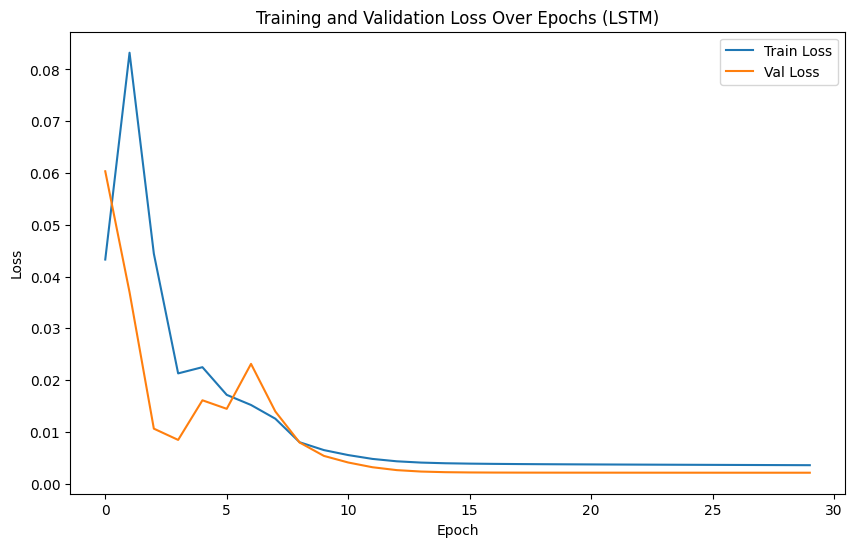

In [ ]:
# ---------------------------------------
# 9. Retrain Final Model with Best Hyperparams
# ---------------------------------------
best_params = study.best_params
model = LSTMModel(input_dim=len(features), hidden_dim=best_params['hidden_dim'], output_dim=len(features)).to(device)
criterion = AsymmetricLoss(ratio=best_params['asymmetric_ratio'])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3)

best_state, _, train_losses, val_losses = train_and_validate(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=30)
model.load_state_dict(best_state)

# Plot training vs validation loss to check for overfitting
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss Over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicted (first 5):
 [[786.1205  782.8806  770.7568  768.1862 ]
 [786.4515  783.2189  771.09064 768.50916]
 [786.9379  783.6923  771.5765  769.1367 ]
 [787.50146 784.2551  772.1487  769.6621 ]
 [788.0746  784.8255  772.73816 770.4396 ]]
Actual (first 5):
 [[778.81 789.63 775.8  786.14]
 [788.36 791.34 783.16 786.9 ]
 [786.08 794.48 785.02 794.02]
 [795.26 807.9  792.2  806.15]
 [806.4  809.97 802.83 806.65]]
Test MSE: 643.7073, RMSE: 25.3714, MAE: 22.4846


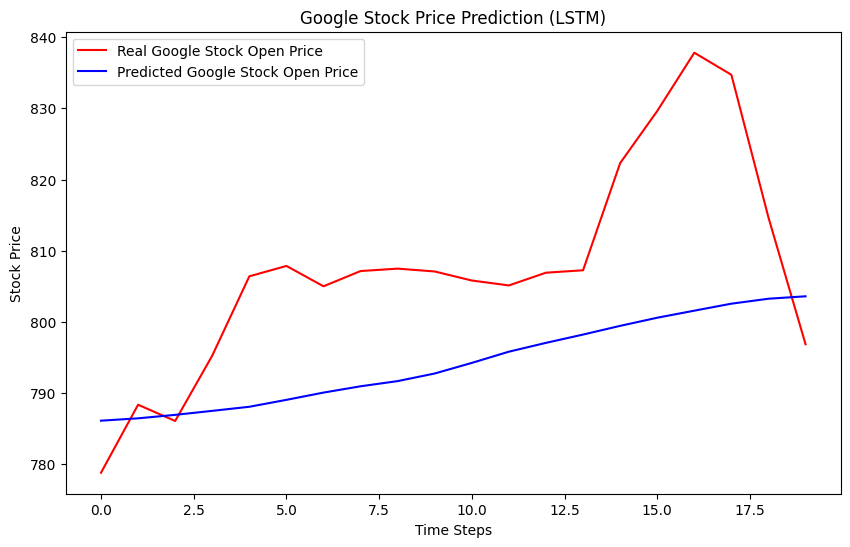

In [ ]:
# ---------------------------------------
# 10. Evaluate on Test Set
# ---------------------------------------
# Ensure proper alignment by taking last N days of training plus test data
test_input = np.concatenate((training_set[-N:], test_set), axis=0)
test_input_scaled = scaler.transform(test_input)

X_test = []
for i in range(N, len(test_input_scaled)):
    X_test.append(test_input_scaled[i-N:i, :])
X_test = np.array(X_test)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    predicted_scaled = model(X_test_torch).cpu().numpy()

predicted_stock_price = scaler.inverse_transform(predicted_scaled.reshape(-1, len(features)))
real_prices = test_data[features].values

print("Predicted (first 5):\n", predicted_stock_price[:5])
print("Actual (first 5):\n", real_prices[:5])

# Compute Evaluation Metrics
mse = mean_squared_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices[:len(predicted_stock_price), :], predicted_stock_price)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Focus on 'Open' price for visualization
real_open_price = real_prices[:len(predicted_stock_price), 0]
predicted_open_price = predicted_stock_price[:, 0]

# Plot predicted vs real prices
plt.figure(figsize=(10,6))
plt.plot(real_open_price, color='red', label='Real Google Stock Open Price')
plt.plot(predicted_open_price, color='blue', label='Predicted Google Stock Open Price')
plt.title('Google Stock Price Prediction (LSTM)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

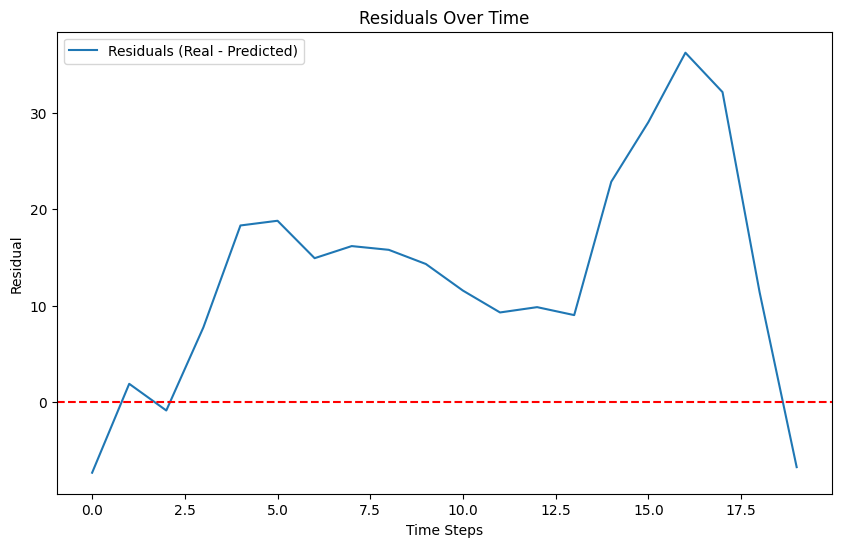

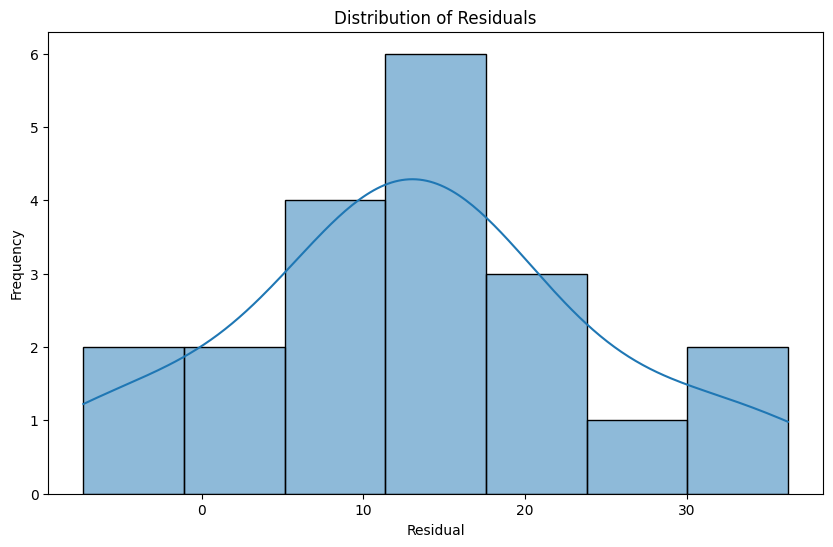

In [ ]:
# ---------------------------------------
# 11. Residual Analysis (Check for Systematic Bias)
# ---------------------------------------
residuals = real_open_price - predicted_open_price

# Plot residuals over time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Residuals (Real - Predicted)')
plt.title('Residuals Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

